# Apache Spark
## Ali Hashir - ah05433@st.habib.edu.pk

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import col, when

#sc is the Spark Context already available at databricks, so we do not need to create it again.
# sc = SparkContext()
# sqlContext = SQLContext(sc)

# from pyspark.sql import SparkSession
sqlContext = SparkSession.builder.appName('abc').getOrCreate()

# Creating RDD (Resilient Distributed Dataset) - fundamental data structure of Spark

In [ ]:
products = sc.textFile("/FileStore/tables/SalesData-1.txt")

In [ ]:
products.first()

Out[263]: 'ProductID\tName\tProductNumber\tColor\tStandardCost\tListPrice\tSize\tWeight\tProductCategoryID\tProductModelID\tSellStartDate\tSellEndDate\tDiscontinuedDate\tThumbNailPhoto\tThumbnailPhotoFileName\trowguid\tModifiedDate'

In [ ]:
print("The data has {} columns".format(len(products.first().split("\t"))))
header = products.first().split("\t")
header

The data has 17 columns
Out[264]: ['ProductID',
 'Name',
 'ProductNumber',
 'Color',
 'StandardCost',
 'ListPrice',
 'Size',
 'Weight',
 'ProductCategoryID',
 'ProductModelID',
 'SellStartDate',
 'SellEndDate',
 'DiscontinuedDate',
 'ThumbNailPhoto',
 'ThumbnailPhotoFileName',
 'rowguid',
 'ModifiedDate']

In [ ]:
head = products.first()
content = products.filter(lambda line: line != head)

In [ ]:
content.first()

Out[266]: '680\tHL Road Frame - Black, 58\tFR-R92B-58\tBlack\t1059.31\t1431.50\t58\t1016.04\t18\t6\t1998-06-01 00:00:00.000\tNULL\tNULL\t0x47494638396150003100F70000000000800000008000808000000080800080008080808080C0C0C0FF000000FF00FFFF000000FFFF00FF00FFFFFFFFFF000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000\tno_image_available_small.gif\t43DD68D6-14A4-461F-9069-55309D90EA7E\t2004-03-11 10:01:36.827'

In [ ]:
content.map(lambda line: len(line.split("\t"))).distinct().collect()[0]

Out[267]: 17

# Example of RDD using Scala

In [ ]:
rdd1 = (content.filter(lambda line: line.split("\t"))
 .map(lambda line: (line.split("\t")))
)
rdd1.take(1)

Out[268]: [['680',
  'HL Road Frame - Black, 58',
  'FR-R92B-58',
  'Black',
  '1059.31',
  '1431.50',
  '58',
  '1016.04',
  '18',
  '6',
  '1998-06-01 00:00:00.000',
  'NULL',
  'NULL',
  '0x47494638396150003100F70000000000800000008000808000000080800080008080808080C0C0C0FF000000FF00FFFF000000FFFF00FF00FFFFFFFFFF000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000',
  'no_image_available_small.gif',
  '43DD68D6-14A4-461F-9069-55309D90EA7E',
  '2004-03-11 10:01:36.827']]

# Converting RDD into Spark Dataframe

In [ ]:
df = rdd1.toDF(header)
df.printSchema()

root
 |-- ProductID: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- ProductNumber: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- StandardCost: string (nullable = true)
 |-- ListPrice: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Weight: string (nullable = true)
 |-- ProductCategoryID: string (nullable = true)
 |-- ProductModelID: string (nullable = true)
 |-- SellStartDate: string (nullable = true)
 |-- SellEndDate: string (nullable = true)
 |-- DiscontinuedDate: string (nullable = true)
 |-- ThumbNailPhoto: string (nullable = true)
 |-- ThumbnailPhotoFileName: string (nullable = true)
 |-- rowguid: string (nullable = true)
 |-- ModifiedDate: string (nullable = true)



# Using Spark Dataframe syntax and SQL Table syntax

In [ ]:
# selecting two columns Name and Weight from original dataframe and convert into their proper datatype. Default is string
df1 = df.select(df.Name, df.Weight.cast("float"))
df1.show(5, truncate=False)

+-------------------------+-------+
|Name                     |Weight |
+-------------------------+-------+
|HL Road Frame - Black, 58|1016.04|
|HL Road Frame - Red, 58  |1016.04|
|Sport-100 Helmet, Red    |null   |
|Sport-100 Helmet, Black  |null   |
|Mountain Bike Socks, M   |null   |
+-------------------------+-------+
only showing top 5 rows



In [ ]:
# convert the above Dataframe into SQL Table
df1.createOrReplaceTempView("df_table")
sqlContext.sql(" SELECT * FROM df_table limit 5").show(truncate=False)

+-------------------------+-------+
|Name                     |Weight |
+-------------------------+-------+
|HL Road Frame - Black, 58|1016.04|
|HL Road Frame - Red, 58  |1016.04|
|Sport-100 Helmet, Red    |null   |
|Sport-100 Helmet, Black  |null   |
|Mountain Bike Socks, M   |null   |
+-------------------------+-------+



In [ ]:
# Casting the weight and price column to float
df = df.withColumn("Weight", df["Weight"].cast('float'))
df = df.withColumn("ListPrice", df["ListPrice"].cast('float'))

# Converting Spark Dataframe into SQL table

In [ ]:
df.createOrReplaceTempView("Product")
sqlContext.sql(" SELECT Name, Weight FROM Product limit 5").show(truncate=False)

+-------------------------+-------+
|Name                     |Weight |
+-------------------------+-------+
|HL Road Frame - Black, 58|1016.04|
|HL Road Frame - Red, 58  |1016.04|
|Sport-100 Helmet, Red    |null   |
|Sport-100 Helmet, Black  |null   |
|Mountain Bike Socks, M   |null   |
+-------------------------+-------+



# Write your solution for Spark Dataframe and Spark SQL. Your output should match with the RDD output

## 1. Find the names and weight of the top 15 products by weight. Sort weight by descending order.

### Using RDD

In [ ]:
(content.filter(lambda line: line.split("\t")[7] != "NULL")
 .map(lambda line: (line.split("\t")[1], float(line.split("\t")[7])))
                     .takeOrdered(15, lambda x : -x[1])
                    )

Out[274]: [('Touring-3000 Blue, 62', 13607.7),
 ('Touring-3000 Yellow, 62', 13607.7),
 ('Touring-3000 Blue, 58', 13562.34),
 ('Touring-3000 Yellow, 58', 13512.45),
 ('Touring-3000 Blue, 54', 13462.55),
 ('Touring-3000 Yellow, 54', 13344.62),
 ('Touring-3000 Yellow, 50', 13213.08),
 ('Touring-3000 Blue, 50', 13213.08),
 ('Touring-3000 Yellow, 44', 13049.78),
 ('Touring-3000 Blue, 44', 13049.78),
 ('Mountain-500 Silver, 52', 13008.96),
 ('Mountain-500 Black, 52', 13008.96),
 ('Mountain-500 Silver, 48', 12891.03),
 ('Mountain-500 Black, 48', 12891.03),
 ('Mountain-500 Silver, 44', 12759.49)]

### Using Spark DataFrame

In [ ]:
cols = ["Name", 'Weight']
df.select(cols).orderBy(col("Weight").desc()).show(15, truncate=False)

+-----------------------+--------+
|Name                   |Weight  |
+-----------------------+--------+
|Touring-3000 Blue, 62  |13607.7 |
|Touring-3000 Yellow, 62|13607.7 |
|Touring-3000 Blue, 58  |13562.34|
|Touring-3000 Yellow, 58|13512.45|
|Touring-3000 Blue, 54  |13462.55|
|Touring-3000 Yellow, 54|13344.62|
|Touring-3000 Blue, 50  |13213.08|
|Touring-3000 Yellow, 50|13213.08|
|Touring-3000 Yellow, 44|13049.78|
|Touring-3000 Blue, 44  |13049.78|
|Mountain-500 Black, 52 |13008.96|
|Mountain-500 Silver, 52|13008.96|
|Mountain-500 Silver, 48|12891.03|
|Mountain-500 Black, 48 |12891.03|
|Mountain-500 Silver, 44|12759.49|
+-----------------------+--------+
only showing top 15 rows



### Using Spark SQL

In [ ]:
sqlContext.sql(" SELECT Name, Weight FROM Product WHERE Weight IS NOT NULL ORDER BY WEIGHT DESC limit 15 ").show(truncate=False)

+-----------------------+--------+
|Name                   |Weight  |
+-----------------------+--------+
|Touring-3000 Yellow, 62|13607.7 |
|Touring-3000 Blue, 62  |13607.7 |
|Touring-3000 Blue, 58  |13562.34|
|Touring-3000 Yellow, 58|13512.45|
|Touring-3000 Blue, 54  |13462.55|
|Touring-3000 Yellow, 54|13344.62|
|Touring-3000 Yellow, 50|13213.08|
|Touring-3000 Blue, 50  |13213.08|
|Touring-3000 Blue, 44  |13049.78|
|Touring-3000 Yellow, 44|13049.78|
|Mountain-500 Black, 52 |13008.96|
|Mountain-500 Silver, 52|13008.96|
|Mountain-500 Black, 48 |12891.03|
|Mountain-500 Silver, 48|12891.03|
|Mountain-500 Silver, 44|12759.49|
+-----------------------+--------+



## 2. Retrieve product details (name, color, size, product model ID) for products where the product model ID is 5

### Using RDD

In [ ]:
(content.filter(lambda line:line.split("\t")[9]=="5")
 .map(lambda line: (line.split("\t")[1],line.split("\t")[3], line.split("\t")[6], line.split("\t")[9])).collect()
)

Out[277]: [('HL Mountain Frame - Silver, 42', 'Silver', '42', '5'),
 ('HL Mountain Frame - Silver, 44', 'Silver', '44', '5'),
 ('HL Mountain Frame - Silver, 48', 'Silver', '48', '5'),
 ('HL Mountain Frame - Silver, 46', 'Silver', '46', '5'),
 ('HL Mountain Frame - Black, 42', 'Black', '42', '5'),
 ('HL Mountain Frame - Black, 44', 'Black', '44', '5'),
 ('HL Mountain Frame - Black, 48', 'Black', '48', '5'),
 ('HL Mountain Frame - Black, 46', 'Black', '46', '5'),
 ('HL Mountain Frame - Black, 38', 'Black', '38', '5'),
 ('HL Mountain Frame - Silver, 38', 'Silver', '38', '5')]

### Using Spark Dataframe

In [ ]:
cols = ["Name", "Color", "Size", "ProductModelID"]
df.select(cols).filter(df.ProductModelID == "5").show(15, truncate=False)

+------------------------------+------+----+--------------+
|Name                          |Color |Size|ProductModelID|
+------------------------------+------+----+--------------+
|HL Mountain Frame - Silver, 42|Silver|42  |5             |
|HL Mountain Frame - Silver, 44|Silver|44  |5             |
|HL Mountain Frame - Silver, 48|Silver|48  |5             |
|HL Mountain Frame - Silver, 46|Silver|46  |5             |
|HL Mountain Frame - Black, 42 |Black |42  |5             |
|HL Mountain Frame - Black, 44 |Black |44  |5             |
|HL Mountain Frame - Black, 48 |Black |48  |5             |
|HL Mountain Frame - Black, 46 |Black |46  |5             |
|HL Mountain Frame - Black, 38 |Black |38  |5             |
|HL Mountain Frame - Silver, 38|Silver|38  |5             |
+------------------------------+------+----+--------------+



### Using Spark SQL

In [ ]:
sqlContext.sql(" SELECT Name, Color, Size, ProductModelID FROM Product WHERE ProductModelID = 5").show(truncate=False)

+------------------------------+------+----+--------------+
|Name                          |Color |Size|ProductModelID|
+------------------------------+------+----+--------------+
|HL Mountain Frame - Silver, 42|Silver|42  |5             |
|HL Mountain Frame - Silver, 44|Silver|44  |5             |
|HL Mountain Frame - Silver, 48|Silver|48  |5             |
|HL Mountain Frame - Silver, 46|Silver|46  |5             |
|HL Mountain Frame - Black, 42 |Black |42  |5             |
|HL Mountain Frame - Black, 44 |Black |44  |5             |
|HL Mountain Frame - Black, 48 |Black |48  |5             |
|HL Mountain Frame - Black, 46 |Black |46  |5             |
|HL Mountain Frame - Black, 38 |Black |38  |5             |
|HL Mountain Frame - Silver, 38|Silver|38  |5             |
+------------------------------+------+----+--------------+



## 3. Retrieve the name and product number of the products that have a color of 'black', 'red', or 'white' and a size of 'S' or 'M'

### Using RDD

In [ ]:
colors = ["White","Black","Red"]
sizes = ["S","M"]

(content.filter(lambda line: line.split("\t")[6] in sizes)
.filter(lambda line: line.split("\t")[3] in colors)
.map(lambda line: (line.split("\t")[1],line.split("\t")[2], line.split("\t")[3],line.split("\t")[6]))
 .collect()
)

Out[280]: [('Mountain Bike Socks, M', 'SO-B909-M', 'White', 'M'),
 ("Men's Sports Shorts, S", 'SH-M897-S', 'Black', 'S'),
 ("Men's Sports Shorts, M", 'SH-M897-M', 'Black', 'M'),
 ("Women's Tights, S", 'TG-W091-S', 'Black', 'S'),
 ("Women's Tights, M", 'TG-W091-M', 'Black', 'M'),
 ('Half-Finger Gloves, S', 'GL-H102-S', 'Black', 'S'),
 ('Half-Finger Gloves, M', 'GL-H102-M', 'Black', 'M'),
 ('Full-Finger Gloves, S', 'GL-F110-S', 'Black', 'S'),
 ('Full-Finger Gloves, M', 'GL-F110-M', 'Black', 'M'),
 ("Women's Mountain Shorts, S", 'SH-W890-S', 'Black', 'S'),
 ("Women's Mountain Shorts, M", 'SH-W890-M', 'Black', 'M'),
 ('Racing Socks, M', 'SO-R809-M', 'White', 'M')]

### Using Spark Dataframe

In [ ]:
cols = ['Name','ProductNumber', 'Color', 'Size']
df.select(cols).filter( (df.Color.isin(colors)) & (df.Size.isin(sizes)) ).show(truncate=False)

+--------------------------+-------------+-----+----+
|Name                      |ProductNumber|Color|Size|
+--------------------------+-------------+-----+----+
|Mountain Bike Socks, M    |SO-B909-M    |White|M   |
|Men's Sports Shorts, S    |SH-M897-S    |Black|S   |
|Men's Sports Shorts, M    |SH-M897-M    |Black|M   |
|Women's Tights, S         |TG-W091-S    |Black|S   |
|Women's Tights, M         |TG-W091-M    |Black|M   |
|Half-Finger Gloves, S     |GL-H102-S    |Black|S   |
|Half-Finger Gloves, M     |GL-H102-M    |Black|M   |
|Full-Finger Gloves, S     |GL-F110-S    |Black|S   |
|Full-Finger Gloves, M     |GL-F110-M    |Black|M   |
|Women's Mountain Shorts, S|SH-W890-S    |Black|S   |
|Women's Mountain Shorts, M|SH-W890-M    |Black|M   |
|Racing Socks, M           |SO-R809-M    |White|M   |
+--------------------------+-------------+-----+----+



### Using Spark SQL

In [ ]:
sqlContext.sql(" SELECT Name, ProductNumber, Color, Size FROM Product WHERE Color in ('White', 'Black', 'Red') and Size in ('S', 'M') ").show(truncate=False)

+--------------------------+-------------+-----+----+
|Name                      |ProductNumber|Color|Size|
+--------------------------+-------------+-----+----+
|Mountain Bike Socks, M    |SO-B909-M    |White|M   |
|Men's Sports Shorts, S    |SH-M897-S    |Black|S   |
|Men's Sports Shorts, M    |SH-M897-M    |Black|M   |
|Women's Tights, S         |TG-W091-S    |Black|S   |
|Women's Tights, M         |TG-W091-M    |Black|M   |
|Half-Finger Gloves, S     |GL-H102-S    |Black|S   |
|Half-Finger Gloves, M     |GL-H102-M    |Black|M   |
|Full-Finger Gloves, S     |GL-F110-S    |Black|S   |
|Full-Finger Gloves, M     |GL-F110-M    |Black|M   |
|Women's Mountain Shorts, S|SH-W890-S    |Black|S   |
|Women's Mountain Shorts, M|SH-W890-M    |Black|M   |
|Racing Socks, M           |SO-R809-M    |White|M   |
+--------------------------+-------------+-----+----+



## 4. Retrieve the product name, product number, color and list price of products whose product number begins with 'BK-'. Retrieve only 15 records and Sort the price in descending order

### Using RDD

In [ ]:
(content.filter(lambda line: "BK" in line.split("\t")[2])
 .map(lambda line: (line.split("\t")[1], line.split("\t")[2], line.split("\t")[3], float(line.split("\t")[5])))
.takeOrdered(15, lambda x: -x[3]))

Out[283]: [('Road-150 Red, 62', 'BK-R93R-62', 'Red', 3578.27),
 ('Road-150 Red, 44', 'BK-R93R-44', 'Red', 3578.27),
 ('Road-150 Red, 48', 'BK-R93R-48', 'Red', 3578.27),
 ('Road-150 Red, 52', 'BK-R93R-52', 'Red', 3578.27),
 ('Road-150 Red, 56', 'BK-R93R-56', 'Red', 3578.27),
 ('Mountain-100 Silver, 38', 'BK-M82S-38', 'Silver', 3399.99),
 ('Mountain-100 Silver, 42', 'BK-M82S-42', 'Silver', 3399.99),
 ('Mountain-100 Silver, 44', 'BK-M82S-44', 'Silver', 3399.99),
 ('Mountain-100 Silver, 48', 'BK-M82S-48', 'Silver', 3399.99),
 ('Mountain-100 Black, 38', 'BK-M82B-38', 'Black', 3374.99),
 ('Mountain-100 Black, 42', 'BK-M82B-42', 'Black', 3374.99),
 ('Mountain-100 Black, 44', 'BK-M82B-44', 'Black', 3374.99),
 ('Mountain-100 Black, 48', 'BK-M82B-48', 'Black', 3374.99),
 ('Road-250 Red, 44', 'BK-R89R-44', 'Red', 2443.35),
 ('Road-250 Red, 48', 'BK-R89R-48', 'Red', 2443.35)]

### Using Spark Dataframe

In [ ]:
cols = ["Name", "ProductNumber", "Color", "ListPrice"]
df.select(cols).filter(df.ProductNumber.startswith("BK-")).orderBy(col("ListPrice").desc()).show(15, truncate=False)


+-----------------------+-------------+------+---------+
|Name                   |ProductNumber|Color |ListPrice|
+-----------------------+-------------+------+---------+
|Road-150 Red, 44       |BK-R93R-44   |Red   |3578.27  |
|Road-150 Red, 56       |BK-R93R-56   |Red   |3578.27  |
|Road-150 Red, 48       |BK-R93R-48   |Red   |3578.27  |
|Road-150 Red, 62       |BK-R93R-62   |Red   |3578.27  |
|Road-150 Red, 52       |BK-R93R-52   |Red   |3578.27  |
|Mountain-100 Silver, 44|BK-M82S-44   |Silver|3399.99  |
|Mountain-100 Silver, 42|BK-M82S-42   |Silver|3399.99  |
|Mountain-100 Silver, 38|BK-M82S-38   |Silver|3399.99  |
|Mountain-100 Silver, 48|BK-M82S-48   |Silver|3399.99  |
|Mountain-100 Black, 42 |BK-M82B-42   |Black |3374.99  |
|Mountain-100 Black, 48 |BK-M82B-48   |Black |3374.99  |
|Mountain-100 Black, 38 |BK-M82B-38   |Black |3374.99  |
|Mountain-100 Black, 44 |BK-M82B-44   |Black |3374.99  |
|Road-250 Red, 44       |BK-R89R-44   |Red   |2443.35  |
|Road-250 Red, 52       |BK-R89

### Using Spark SQL

In [ ]:
sqlContext.sql(" SELECT Name, ProductNumber, Color, ListPrice FROM Product WHERE ProductNumber LIKE 'BK-%' ORDER BY ListPrice DESC limit 15 ").show(truncate=False)

+-----------------------+-------------+------+---------+
|Name                   |ProductNumber|Color |ListPrice|
+-----------------------+-------------+------+---------+
|Road-150 Red, 52       |BK-R93R-52   |Red   |3578.27  |
|Road-150 Red, 44       |BK-R93R-44   |Red   |3578.27  |
|Road-150 Red, 56       |BK-R93R-56   |Red   |3578.27  |
|Road-150 Red, 48       |BK-R93R-48   |Red   |3578.27  |
|Road-150 Red, 62       |BK-R93R-62   |Red   |3578.27  |
|Mountain-100 Silver, 42|BK-M82S-42   |Silver|3399.99  |
|Mountain-100 Silver, 44|BK-M82S-44   |Silver|3399.99  |
|Mountain-100 Silver, 38|BK-M82S-38   |Silver|3399.99  |
|Mountain-100 Silver, 48|BK-M82S-48   |Silver|3399.99  |
|Mountain-100 Black, 42 |BK-M82B-42   |Black |3374.99  |
|Mountain-100 Black, 48 |BK-M82B-48   |Black |3374.99  |
|Mountain-100 Black, 38 |BK-M82B-38   |Black |3374.99  |
|Mountain-100 Black, 44 |BK-M82B-44   |Black |3374.99  |
|Road-250 Red, 44       |BK-R89R-44   |Red   |2443.35  |
|Road-250 Red, 48       |BK-R89

## 5. Visualize Average List Price per Color and Average List Price per Size. Discuss/Explain your results.

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
%matplotlib inline

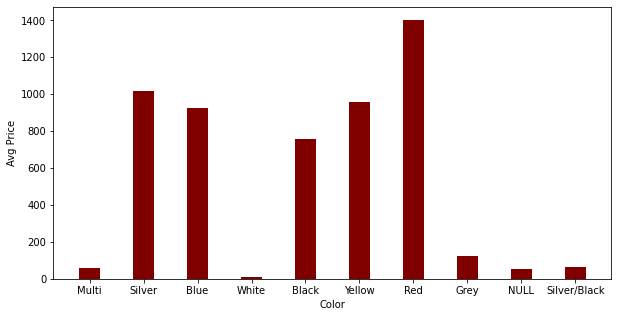

In [ ]:
avg_price_of_colors = df.groupBy("Color").avg("ListPrice").collect()

colors = []
avg_prices = []

for row in avg_price_of_colors:
  colors.append(row['Color'])
  avg_prices.append(row['avg(ListPrice)'])
  

fig = plt.figure(figsize = (10, 5))
plt.bar(colors, avg_prices, color ='maroon', width = 0.4)
plt.xlabel('Color')
plt.ylabel('Avg Price')
plt.show()


We can in the above bar graph that average price for the color red is highest and the average price for the color white is the lowest. Silver is second, Yellow is third, and Blue is fourth. This also may tell us that the color red (and similar colorful colors) is in huge demand and more appealing to the customers which makes the average price high and the colors like white or grey or multi are not that much in demand.

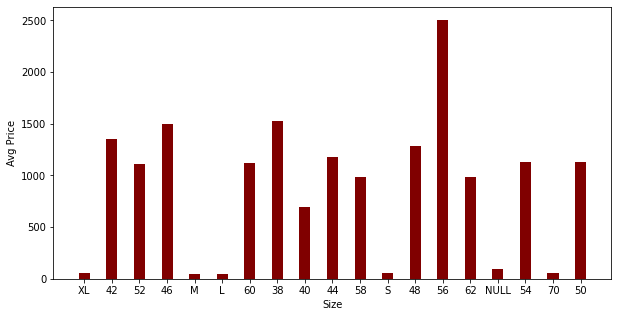

In [ ]:
avg_price_of_colors = df.groupBy("Size").avg("ListPrice").collect()

sizes = []
avg_prices = []

for row in avg_price_of_colors:
  sizes.append(row['Size'])
  avg_prices.append(row['avg(ListPrice)'])
  

fig = plt.figure(figsize = (10, 5))
plt.bar(sizes, avg_prices, color ='maroon', width = 0.4)
plt.xlabel('Size')
plt.ylabel('Avg Price')
plt.show()


In the above graph we can see that the average price for size 56 is the highest which means that it has the best demand and the average price for size XML, size M, size L, and size S are very low which means that they are low in demand. Size 46, size 38, size 42 are also relatively high in demand.

## 5. Visualize Total Count per Size. Discuss/Explain your results.

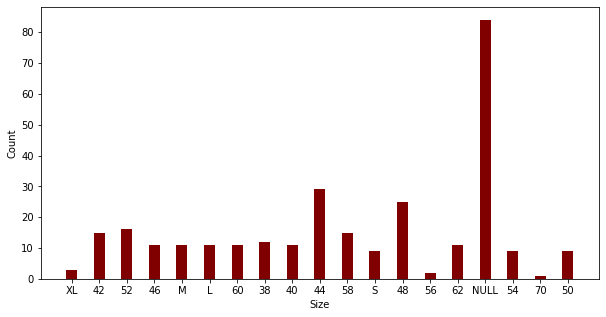

In [ ]:
counts_per_size = df.groupBy("Size").count().collect()

sizes = []
counts = []

for row in counts_per_size:
  sizes.append(row['Size'])
  counts.append(row['count'])
  

fig = plt.figure(figsize = (10, 5))
plt.bar(sizes, counts, color ='maroon', width = 0.4)
plt.xlabel('Size')
plt.ylabel('Count')
plt.show()


In the above graph we can see that the size 44 has the highest count, and size 48 is the second highest, whereas the size XL and size 56 are lowest in count. This may mean that the sizes with the highest counts are good for profit and are high in production whereas the ones with low count are not produced that much. Many products exist which have a size of NULL such that there is no size.

# Using Machine Learning Library (For Practice)

In [ ]:
dfall = df.select(df.Weight.cast("float"), df.Size.cast("float"), df.ListPrice.cast("float"))
dfall.show(5, truncate=False)

+-------+----+---------+
|Weight |Size|ListPrice|
+-------+----+---------+
|1016.04|58.0|1431.5   |
|1016.04|58.0|1431.5   |
|null   |null|34.99    |
|null   |null|34.99    |
|null   |null|9.5      |
+-------+----+---------+
only showing top 5 rows



In [ ]:
dfall = dfall.na.drop("any")

In [ ]:
feature_columns = dfall.columns[:-1] # here we omit the final column for prediction
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")

In [ ]:
data_2 = assembler.transform(dfall)

In [ ]:
data_2.show()

+-------+----+---------+--------------------+
| Weight|Size|ListPrice|            features|
+-------+----+---------+--------------------+
|1016.04|58.0|   1431.5|[1016.03997802734...|
|1016.04|58.0|   1431.5|[1016.03997802734...|
|1043.26|62.0|   1431.5|[1043.26000976562...|
| 961.61|44.0|   1431.5|[961.609985351562...|
| 979.75|48.0|   1431.5|       [979.75,48.0]|
|  997.9|52.0|   1431.5|[997.900024414062...|
|1016.04|56.0|   1431.5|[1016.03997802734...|
|1115.83|58.0|   337.22|[1115.82995605468...|
| 1124.9|60.0|   337.22|[1124.90002441406...|
|1133.98|62.0|   337.22|[1133.97998046875...|
|1052.33|44.0|   337.22|[1052.32995605468...|
|1070.47|48.0|   337.22|[1070.46997070312...|
|1088.62|52.0|   337.22|[1088.61999511718...|
|1115.83|58.0|   337.22|[1115.82995605468...|
| 1124.9|60.0|   337.22|[1124.90002441406...|
|1133.98|62.0|   337.22|[1133.97998046875...|
|1006.97|44.0|   594.83|[1006.96997070312...|
|1025.11|48.0|   594.83|[1025.10998535156...|
|1043.26|52.0|   594.83|[1043.2600

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
algo = LinearRegression(featuresCol="features", labelCol="ListPrice")

In [ ]:
model = algo.fit(data_2)

In [ ]:
evaluation_summary = model.evaluate(data_2)

In [ ]:
evaluation_summary.rootMeanSquaredError

Out[298]: 862.8415344138206

In [ ]:
evaluation_summary.r2

Out[299]: 0.1001938970427878